# reaction-network (Demo Notebook)
### Author: Matthew McDermott
### Date: February 2021

The following notebook serves as a walkthrough for the use of the *reaction-network* code, which is imported as *rxn_network*. 

In the following examples, we recreate the results/analysis originally presented in the manuscript: 

*Matthew J. McDermott, Shyam Dwaraknath, and Kristin A. Persson. “A graph-based network for predicting chemical reaction pathways in solid-state materials synthesis” (2021)*.


## Imports
The following imports are required to access the Materials Project database and construct the network.  Don't worry if you see an error regarding the cairo package for drawing the networks; this part is optional.

In [1]:
import logging
import pickle
import json
import numpy as np
import itertools
from datetime import date

from monty.json import MontyDecoder

import graph_tool.all as gt

from rxn_network.core import ReactionNetwork
from rxn_network.entries import CustomEntry, GibbsComputedStructureEntry
from rxn_network.helpers import find_interdependent_rxns
from rxn_network.reaction import Reaction, ComputedReaction

from pymatgen import MPRester, Structure, Element, Composition
from pymatgen.analysis.phase_diagram import PhaseDiagram

logging.info("Logging initialized")
%load_ext autoreload
%autoreload 2


Note: this code uses Dask to parallelize the building of the reaction network graph. The client is initialized below, and the Dask web GUI can be accessed via a local HTTP server (see Dask documentation for further details).

In [2]:
from dask.distributed import Client
client = Client()
logging.info("Logging initialized")
print("Client initialized...")

/Users/mcdermott/miniconda3/envs/gt/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 62661 instead
  warnings.warn(


Client initialized...


## Main script
The following function's code can be run as a standalone script to generate the reaction network and perform pathfinding. In the first example that follows, we will break down each of these steps so it is clear what each section of the script is doing. In the following sections, we will only povide the input parameters and refer you to running the main script yourself.

In [34]:
def run_reaction_network_analysis(entries, precursors, targets, temp, include_metastable, k, chempots, max_num_combos, interpolate_comps=[]):
    rn = ReactionNetwork(entries, temp=temp, interpolate_comps=interpolate_comps, 
                         include_metastable=include_metastable)

    precursors_comps = [Composition(s) for s in precursors]
    targets_comps = [Composition(t) for t in targets]

    precursor_entries = []
    target_entries = []

    for entry in rn._filtered_entries:
        if entry.composition.reduced_composition in precursors_comps:
            precursor_entries.append(entry)
        elif entry.composition.reduced_composition in targets_comps:
            target_entries.append(entry)

    rn.generate_rxn_network(precursor_entries,target_entries)
    paths = rn.find_all_rxn_pathways(k=k, precursors=precursor_entries, consider_crossover_rxns=True, 
                                         max_num_combos=max_num_combos, filter_interdependent=False,
                                        chempots=chempots)
    return rn, paths

# Example 1: YMnO$_3$ assisted metathesis

## Building the phase diagram entries

First, we acquire Materials Project entries for the C-Cl-Li-Mn-O-Y chemical system via the MPRester API; please see materialsproject.org to create an account and get an API key.

Note: *You may also use your own thermodynamic database entries, but they must be initialized as ComputedStructureEntry objects in pymatgen*.

In [4]:
chemsys = "C-Cl-Li-Mn-O-Y"
with MPRester() as mpr:  # requires API key from Materials Project
    all_entries = mpr.get_entries_in_chemsys(chemsys, inc_structure="final") 

/Users/mcdermott/PycharmProjects/pymatgen/pymatgen/ext/matproj.py:581: FutureWarning: __init__ is deprecated
MaterialsProjectCompatibility will be updated with new correction classes as well as new values of corrections and uncertainties in 2020
  entries = MaterialsProjectCompatibility().process_entries(entries)


Let's first see how many of these entries are stable at T = 0 K by constructing a compositional phase diagram:

In [5]:
pd_mp = PhaseDiagram(all_entries)
print(pd_mp)

Li-Y-Mn-C-Cl-O phase diagram
53 stable phases: 
Y4C7, Y2O3, YCCl, Li2O2, LiMn(CO3)2, Mn3O4, Mn23C6, Y4C5, Mn2O3, MnO2, YMn2O5, Y3C4, Y(ClO4)3, O2, Li2O, Mn8Cl3O10, YClO, CO2, Li2MnO3, Li6MnO4, MnCO3, Li, YCl3, YMnO3, Cl2, Y, LiYO2, Y10Mn13C18, YMn12, Y2Cl3, Li11Mn13O32, LiCl, MnCl2, Mn, CCl4, LiC12, Y2C, Li9Mn14O32, Y2Mn2O7, LiMn2O4, Li4Mn5O12, LiClO4, MnO, ClO3, Li9Mn20O40, C, Cl2O7, Cl2O, Mn7C3, Li2CO3, LiMnO2, ClO2, LiO8


When we initialize the network in the next section, it will attempt to estimate the finite temperature phase diagram via a Gibbs estimation model, such as the SISSO model from Bartel et al. Let's see what that does to the phase diagram at T = 900 K:

In [6]:
gibbs_entries = GibbsComputedStructureEntry.from_pd(pd_mp, temp=900)
pd_gibbs = PhaseDiagram(gibbs_entries)
print(pd_gibbs)

Li-Y-Mn-C-Cl-O phase diagram
38 stable phases: 
O2, Li2MnCO4, MnO2, LiMn2O4, CCl2O, MnO, Li2CO3, Li4Mn5O12, Mn, Li2O, Mn2O3, Y4C5, Y10Mn13C18, Y2Mn2O7, YMnO3, CO2, YMn2O5, Li, Mn3O4, YClO, MnCO3, YMn12, Y2C, YCCl, LiMnO2, CCl3, C, Y2O3, MnCl2, Cl2, Y4C7, Li2Mn(CO3)2, YCl3, Mn8Cl3O10, Y, LiC12, LiCl, Li2MnO3


It appears that many structures are destabilized at high temperature according to the Gibbs SISSO descriptor. This will affect how we filter entries to include in the network.

## Creating the reaction network

To create the reaction network, we must first initialize a ReactionNetwork object with a list of ComputedStructureEntry objects (at T = 0 K). This performs necessary preprocessing steps on the list of entries, such as converting them to *GibbsComputedStructureEntry* objects and filtering for thermodynamic stability. Please see the code documentation for more description on the input parameters. In the example below, we will be using a thermodynamic stability cutoff of +30 meV/atom above hull.

In [7]:
rn = ReactionNetwork(all_entries, n=2, temp=900, include_metastable=0.0) # include entries <= 30 meV/atom above hull

INFO:ReactionNetwork:Initializing network with 38 entries: 
O2, Li2CO3, Li2MnCO4, Li2O, MnO2, LiMn2O4, CCl2O, MnO, Li4Mn5O12, Mn, Mn2O3, Y4C5, Y10Mn13C18, Y2Mn2O7, YMnO3, CO2, YMn2O5, Li, Mn3O4, YClO, MnCO3, YMn12, Y2C, LiCl, YCCl, LiMnO2, CCl3, C, Y2O3, MnCl2, Cl2, Li2Mn(CO3)2, Y4C7, YCl3, Mn8Cl3O10, Y, LiC12, Li2MnO3


To actually create the reaction network graph, we must specify both a list of precursor entries and list of target entries. Either (or both) of these can also be empty; if so, the network will treat these precursor/target nodes as "dummy" nodes, meaning that they will link into/out of every node in the network.

The assisted metathesis reaction reported by Todd & Neilson (2019) we would like to study is the following:

$$ Mn_2O_3 + 2 YCl_3 + 3Li_2CO_3 -> 2YMnO_3 + 6LiCl + 3CO_2 $$

We first identify the compositions of this reaction and verify that it is correct by having it automatically balanced:

In [8]:
precursors = ["Mn2O3", "YCl3","Li2CO3"]
targets = ["YMnO3","CO2","LiCl"]

precursors = [Composition(s) for s in precursors]
targets = [Composition(t) for t in targets]

net_rxn = Reaction(precursors,targets)
print(f"Net RXN: {net_rxn}")

Net RXN: 0.5 Mn2O3 + YCl3 + 1.5 Li2CO3 -> YMnO3 + 1.5 CO2 + 3 LiCl


We then need to select which entries correspond to the precursors and targets. If we only know the compositions we want, we need to iterate through all of the entries to find them:

In [9]:
precursor_entries = []
target_entries = []

for entry in rn._filtered_entries:
    if entry.composition.reduced_composition in precursors:
        precursor_entries.append(entry)
    elif entry.composition.reduced_composition in targets:
        target_entries.append(entry)

Finally, we generate the reaction network itself. This process iterates through all possible chemical reactions and creates weighted edges using the designated cost function. 

**IMPORTANT NOTE: this particular graph will likely take 5-10 minutes to generate, depending on your CPU specs.** The progress of the calculation can be checked via the Dask GUI. We strongly recommend you use computing resources for performing these calculations if available to you.

In [10]:
rn.generate_rxn_network(precursor_entries,target_entries,"softplus")

INFO:ReactionNetwork:Generating reactions by chemical subsystem...
INFO:ReactionNetwork:Graph creation took 25.1 seconds.
INFO:ReactionNetwork:Created graph with 1485 nodes and 7595 edges.


## Finding shortest pathways

Now that the graph is  constructed, we can look for shortest paths on the graph to a specific target. For example, we can look at the shortest paths from the precursors to YMnO$_3$ alone.

In [11]:
ymno3_entry = [t for t in target_entries if t.composition.reduced_formula == "YMnO3"][0]
rn.set_target(ymno3_entry)

paths = rn.find_k_shortest_paths(10)

9 Mn2O3 + 2 YCl3 -> Y2Mn2O7 + 2 Mn8Cl3O10 (dG = -0.015 eV/atom) 
0.5 Y2Mn2O7 + 0.5 Mn2O3 -> MnO2 + YMnO3 (dG = 0.018 eV/atom) 
Total Cost: 0.531 

5 Mn2O3 + YCl3 -> YMn2O5 + Mn8Cl3O10 (dG = -0.025 eV/atom) 
YMn2O5 -> MnO2 + YMnO3 (dG = 0.061 eV/atom) 
Total Cost: 0.539 

9 Mn2O3 + 2 YCl3 -> Y2Mn2O7 + 2 Mn8Cl3O10 (dG = -0.015 eV/atom) 
2 Y2Mn2O7 -> O2 + 4 YMnO3 (dG = 0.058 eV/atom) 
Total Cost: 0.54 

Mn2O3 + Li2CO3 -> Li2MnO3 + MnCO3 (dG = -0.026 eV/atom) 
YCl3 + MnCO3 -> CCl3 + YMnO3 (dG = 0.404 eV/atom) 
Total Cost: 0.634 

Li2CO3 -> Li2O + CO2 (dG = 0.145 eV/atom) 
0.5 Li2O + 0.3333 YCl3 -> LiCl + 0.1667 Y2O3 (dG = -0.306 eV/atom) 
0.5 Mn2O3 + 0.5 Y2O3 -> YMnO3 (dG = -0.048 eV/atom) 
Total Cost: 0.756 

Li2CO3 -> Li2O + CO2 (dG = 0.145 eV/atom) 
0.5 Li2O + 0.3333 YCl3 -> LiCl + 0.1667 Y2O3 (dG = -0.306 eV/atom) 
0.5 Mn2O3 + 1.5 Y2O3 -> YMnO3 + Y2O3 (dG = -0.024 eV/atom) 
Total Cost: 0.761 

Li2CO3 -> Li2O + CO2 (dG = 0.145 eV/atom) 
0.5 Li2O + 0.3333 YCl3 -> LiCl + 0.1667 Y2O3 (dG =

While this is nice for understanding which reaction(s) lead to YMnO$_3$, this pathway identification contains no enformcent of conservation of mass. Since we know the stoichiometric coefficients of the **net** reaction, we need to combine these shortest paths in a logical way.

Thus net reaction pathways are identified by finding the k shortest paths to each target, and then attempting to combine identified reactions to form a set that satisifies the stoichiometry of the net reaction. 

You will see in the output below: 1) the k-shortest paths to each target, 2) a step showing the progress of identification of crossover reactions, and 3) a printed list of all reactions being considered during postprocessing.

**IMPORTANT NOTE: the k-shortest paths algorithm (Yen's algorithm) typically performs very quickly, but the postprocessing of combinations can take some time to generate and balance combinations. Even though it is parallelized, this step may take 10-20 mins depending on your computing specs.** We again strongly recommend the use of computing resources for this task.

In [12]:
k = 20
max_num_combos = 4
chempots = {Element("O"):0}

paths = rn.find_all_rxn_pathways(k=k, precursors=precursor_entries, targets=target_entries,
                                 consider_crossover_rxns=True, max_num_combos=max_num_combos, 
                                 filter_interdependent=False, chempots=chempots)

INFO:ReactionNetwork:NET RXN: 0.1667 Mn2O3 + 0.5 Li2CO3 + 0.3333 YCl3 -> LiCl + 0.5 CO2 + 0.3333 YMnO3 



PATHS to LiCl 

--------------------------------------- 

Li2CO3 -> Li2O + CO2 (dG = 0.145 eV/atom) 
0.5 Li2O + 0.3333 YCl3 -> LiCl + 0.1667 Y2O3 (dG = -0.306 eV/atom) 
Total Cost: 0.502 

Li2CO3 -> Li2O + CO2 (dG = 0.145 eV/atom) 
Li2O + YCl3 -> YClO + 2 LiCl (dG = -0.281 eV/atom) 
Total Cost: 0.507 

Mn2O3 + 2 Li2CO3 -> Li2Mn(CO3)2 + Li2MnO3 (dG = -0.061 eV/atom) 
Mn2O3 + 2 Li2MnO3 -> Li2O + 2 LiMn2O4 (dG = 0.053 eV/atom) 
0.5 Li2O + 0.3333 YCl3 -> LiCl + 0.1667 Y2O3 (dG = -0.306 eV/atom) 
Total Cost: 0.73 

Mn2O3 + Li2CO3 -> MnO2 + Li2MnCO4 (dG = 0.022 eV/atom) 
Li2CO3 + Li2MnCO4 -> Li2O + Li2Mn(CO3)2 (dG = -0.013 eV/atom) 
0.5 Li2O + 0.3333 YCl3 -> LiCl + 0.1667 Y2O3 (dG = -0.306 eV/atom) 
Total Cost: 0.733 

Mn2O3 + 2 Li2CO3 -> Li2Mn(CO3)2 + Li2MnO3 (dG = -0.061 eV/atom) 
Mn2O3 + 2 Li2MnO3 -> Li2O + 2 LiMn2O4 (dG = 0.053 eV/atom) 
Li2O + YCl3 -> YClO + 2 LiCl (dG = -0.281 eV/atom) 
Total Cost: 0.735 

Mn2O3 + Li2CO3 -> Li2MnO3 + MnCO3 (dG = -0.026 eV/atom) 
Mn2O3 + 2 Li2MnO3 -> Li

  2%|▏         | 6/276 [00:00<00:05, 46.14it/s]

9 Mn2O3 + 2 YCl3 -> Y2Mn2O7 + 2 Mn8Cl3O10 (dG = -0.015 eV/atom) 
0.5 Y2Mn2O7 + 0.5 Mn2O3 -> MnO2 + YMnO3 (dG = 0.018 eV/atom) 
Total Cost: 0.531 

5 Mn2O3 + YCl3 -> YMn2O5 + Mn8Cl3O10 (dG = -0.025 eV/atom) 
YMn2O5 -> MnO2 + YMnO3 (dG = 0.061 eV/atom) 
Total Cost: 0.539 

9 Mn2O3 + 2 YCl3 -> Y2Mn2O7 + 2 Mn8Cl3O10 (dG = -0.015 eV/atom) 
2 Y2Mn2O7 -> O2 + 4 YMnO3 (dG = 0.058 eV/atom) 
Total Cost: 0.54 

Mn2O3 + Li2CO3 -> Li2MnO3 + MnCO3 (dG = -0.026 eV/atom) 
YCl3 + MnCO3 -> CCl3 + YMnO3 (dG = 0.404 eV/atom) 
Total Cost: 0.634 

Li2CO3 -> Li2O + CO2 (dG = 0.145 eV/atom) 
0.5 Li2O + 0.3333 YCl3 -> LiCl + 0.1667 Y2O3 (dG = -0.306 eV/atom) 
0.5 Mn2O3 + 0.5 Y2O3 -> YMnO3 (dG = -0.048 eV/atom) 
Total Cost: 0.756 

Li2CO3 -> Li2O + CO2 (dG = 0.145 eV/atom) 
0.5 Li2O + 0.3333 YCl3 -> LiCl + 0.1667 Y2O3 (dG = -0.306 eV/atom) 
0.5 Mn2O3 + 1.5 Y2O3 -> YMnO3 + Y2O3 (dG = -0.024 eV/atom) 
Total Cost: 0.761 

Li2CO3 -> Li2O + CO2 (dG = 0.145 eV/atom) 
0.5 Li2O + 0.3333 YCl3 -> LiCl + 0.1667 Y2O3 (dG =

100%|██████████| 276/276 [00:18<00:00, 15.16it/s]
INFO:ReactionNetwork:Considering 60 reactions...
0it [00:00, ?it/s]

[Li2CO3 -> Li2O + CO2,
 0.5 Li2O + 0.3333 YCl3 -> LiCl + 0.1667 Y2O3,
 Li2O + YCl3 -> YClO + 2 LiCl,
 Mn2O3 + 2 Li2CO3 -> Li2Mn(CO3)2 + Li2MnO3,
 Mn2O3 + 2 Li2MnO3 -> Li2O + 2 LiMn2O4,
 Mn2O3 + Li2CO3 -> MnO2 + Li2MnCO4,
 Li2CO3 + Li2MnCO4 -> Li2O + Li2Mn(CO3)2,
 Mn2O3 + Li2CO3 -> Li2MnO3 + MnCO3,
 0.5 Mn2O3 + 0.5 Li2CO3 -> LiMnO2 + 0.5 CO2,
 2 Mn2O3 + 4 Li2CO3 -> O2 + 4 Li2MnCO4,
 1.667 Li2MnO3 -> Li2O + 0.3333 Li4Mn5O12,
 Mn2O3 -> MnO + MnO2,
 MnO + 2 Li2CO3 -> Li2O + Li2Mn(CO3)2,
 0.5 O2 + Li2MnCO4 -> CO2 + Li2MnO3,
 1.5 MnO2 + 0.5 Li2MnCO4 -> LiMn2O4 + 0.5 CO2,
 2 Mn2O3 -> MnO2 + Mn3O4,
 MnO2 + Li2CO3 -> CO2 + Li2MnO3,
 Mn2O3 + MnCO3 -> CO2 + Mn3O4,
 2.5 MnO2 + Li2CO3 -> CO2 + 0.5 Li4Mn5O12,
 Li2CO3 + MnCO3 -> CO2 + Li2MnCO4,
 0.5 MnO2 + 0.5 Li2MnCO4 -> LiMnO2 + 0.5 CO2,
 Li2Mn(CO3)2 -> CO2 + Li2MnCO4,
 MnCO3 -> MnO + CO2,
 2 Mn2O3 -> Mn + 3 MnO2,
 9 Mn2O3 + 2 YCl3 -> Y2Mn2O7 + 2 Mn8Cl3O10,
 0.5 Y2Mn2O7 + 0.5 Mn2O3 -> MnO2 + YMnO3,
 5 Mn2O3 + YCl3 -> YMn2O5 + Mn8Cl3O10,
 YMn2O5 -> 

1it [00:05,  5.20s/it]
1it [00:00, 25.89it/s]
1it [00:00,  3.03it/s]
INFO:ReactionNetwork:Generating and filtering size 4 pathways...
1it [00:05,  5.48s/it]


Let's check out the results. We should see several balanced pathways stored in the **paths** list object.

In [13]:
for num, path in enumerate(paths):
    print(f"Path {num+1}:")
    print(path)

Path 1:
Li2CO3 -> Li2O + CO2 (dG = 0.145 eV/atom) 
0.5 Li2O + 0.3333 YCl3 -> LiCl + 0.1667 Y2O3 (dG = -0.306 eV/atom) 
0.5 Mn2O3 + 0.5 Y2O3 -> YMnO3 (dG = -0.048 eV/atom) 

Total Cost: 0.238 | Average Cost: 0.079


Path 2:
0.5 Li2O + 0.3333 YCl3 -> LiCl + 0.1667 Y2O3 (dG = -0.306 eV/atom) 
Li2CO3 + Li2MnCO4 -> Li2O + Li2Mn(CO3)2 (dG = -0.013 eV/atom) 
Li2Mn(CO3)2 -> Li2MnCO4 + CO2 (dG = 0.096 eV/atom) 
0.5 Mn2O3 + 0.5 Y2O3 -> YMnO3 (dG = -0.048 eV/atom) 

Total Cost: 0.24 | Average Cost: 0.06


Path 3:
0.5 Mn2O3 + 0.5 Y2O3 -> YMnO3 (dG = -0.048 eV/atom) 
Li2CO3 + YCl3 -> CO2 + YClO + 2 LiCl (dG = -0.11 eV/atom) 
Li2CO3 + 2 YClO -> CO2 + 2 LiCl + Y2O3 (dG = -0.034 eV/atom) 

Total Cost: 0.248 | Average Cost: 0.083


Path 4:
Li2CO3 -> Li2O + CO2 (dG = 0.145 eV/atom) 
0.5 Mn2O3 + 0.5 Y2O3 -> YMnO3 (dG = -0.048 eV/atom) 
Li2CO3 + YCl3 -> CO2 + YClO + 2 LiCl (dG = -0.11 eV/atom) 
0.5 Li2O + YClO -> LiCl + 0.5 Y2O3 (dG = -0.142 eV/atom) 

Total Cost: 0.249 | Average Cost: 0.062


Path 5:
Li2

### Filtering/ranking the candidates

As discussed in the paper, several of these reaction pathways either involve interdependent steps or form hypothetical compounds that are like unsynthesizable. Hence it becomes advantageous to construct some filters to reduce the set of pathways down to the most reasonable candidates. We do that here:

In [33]:
cleaned_paths = set()
for idx, p in enumerate(paths):
    interdependent, consolidated_rxn = find_interdependent_rxns(p, precursors, verbose=False)
    if interdependent:
        print(f"Path {idx+1} removed")
        continue
    cleaned_paths.add(p)

Path 2 removed
Path 5 removed


In [35]:
hypothetical_phases = ["Li3MnO3","Li2MnCO5","Li2MnCO4"]
hypothetical_phases = {Composition(c) for c in hypothetical_phases}

for idx, p in enumerate(cleaned_paths.copy()):
    if set(p.all_comp) & hypothetical_phases:
        cleaned_paths.remove(p)
        
cleaned_paths = sorted(list(cleaned_paths), key=lambda x: x.total_cost)

The final, filtered set of candidate reaction pathways is below:

In [38]:
for num, path in enumerate(cleaned_paths):
    print(f"Path {num+1}:")
    print(path)

Path 1:
Li2CO3 -> Li2O + CO2 (dG = 0.145 eV/atom) 
0.5 Li2O + 0.3333 YCl3 -> LiCl + 0.1667 Y2O3 (dG = -0.306 eV/atom) 
0.5 Mn2O3 + 0.5 Y2O3 -> YMnO3 (dG = -0.048 eV/atom) 

Total Cost: 0.238 | Average Cost: 0.079


Path 2:
0.5 Mn2O3 + 0.5 Y2O3 -> YMnO3 (dG = -0.048 eV/atom) 
Li2CO3 + YCl3 -> CO2 + YClO + 2 LiCl (dG = -0.11 eV/atom) 
Li2CO3 + 2 YClO -> CO2 + 2 LiCl + Y2O3 (dG = -0.034 eV/atom) 

Total Cost: 0.248 | Average Cost: 0.083


Path 3:
Li2CO3 -> Li2O + CO2 (dG = 0.145 eV/atom) 
0.5 Mn2O3 + 0.5 Y2O3 -> YMnO3 (dG = -0.048 eV/atom) 
Li2CO3 + YCl3 -> CO2 + YClO + 2 LiCl (dG = -0.11 eV/atom) 
0.5 Li2O + YClO -> LiCl + 0.5 Y2O3 (dG = -0.142 eV/atom) 

Total Cost: 0.249 | Average Cost: 0.062


Path 4:
Li2CO3 + Mn2O3 -> CO2 + 2 LiMnO2 (dG = 0.007 eV/atom) 
Li2CO3 + YCl3 -> CO2 + YClO + 2 LiCl (dG = -0.11 eV/atom) 
YClO + LiMnO2 -> YMnO3 + LiCl (dG = -0.069 eV/atom) 

Total Cost: 0.249 | Average Cost: 0.083


Path 5:
Li2CO3 -> Li2O + CO2 (dG = 0.145 eV/atom) 
Li2O + YCl3 -> YClO + 2 LiC

## Plotting the network

There are many, many methods for plotting large graphs. One of the more useful approaches is to use an interactive interface such as the one provided by **Graphistry Hub**, which was also used to create the illustations in the paper. 

If you wish to use Graphistry Hub, you may sign up for an account and use their Python API (pygraphistry).

Another option is to use the built-in drawing in graph-tool, atlhough it often requires more wrangling to get insightful results. For example, this might look like the following, where we generate and then draw a filtered graph where zero-weight edges have been removed. This essentially just shows the "sub-networks" of chemical reactions broken down by smaller systems within the bigger chemical system. These sub-networks are connceted to each other via the zero-weight edges.

In [39]:
rn.g.ep["zero_cost"] = rn.g.new_edge_property("bool")
for s,t,weight in rn.g.iter_edges(eprops=[rn.g.ep["weight"]]):
    rn.g.ep["zero_cost"][rn.g.edge(s,t)] = (weight!=0)
    
filtered_graph = gt.GraphView(rn.g, efilt=rn.g.ep.zero_cost)

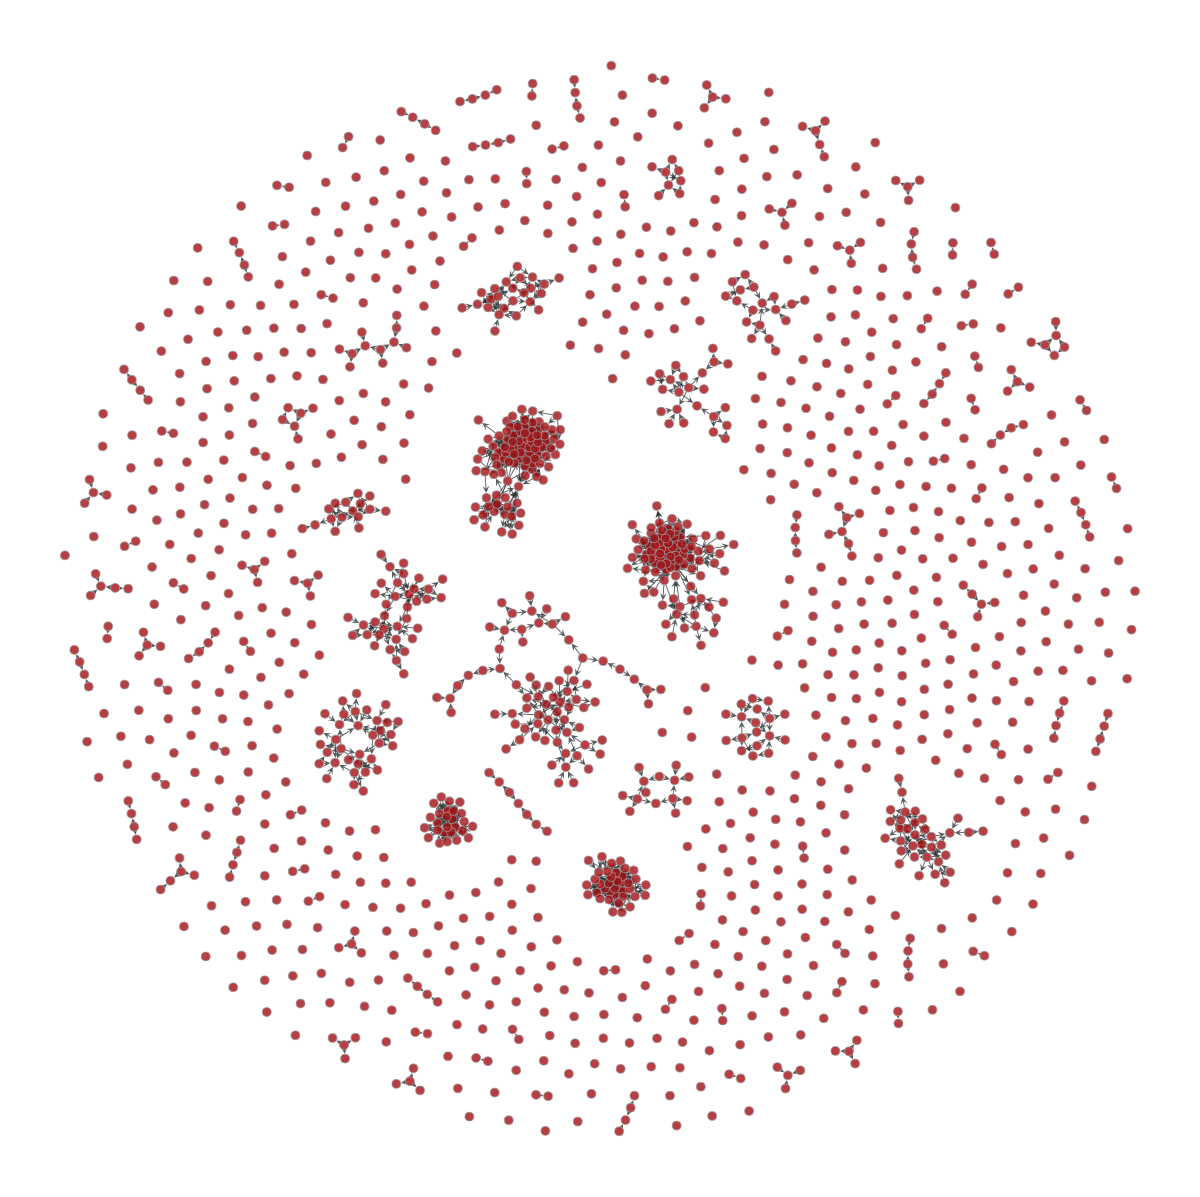

In [40]:
gt.graph_draw(filtered_graph);

There are many more insightful plots (e.g. histograms) you can make simply by using the built-in property maps of the graph-tool object. For example, you can plot the relative counts of the different sub-chemical systems represented in the graph (requires seaborn):

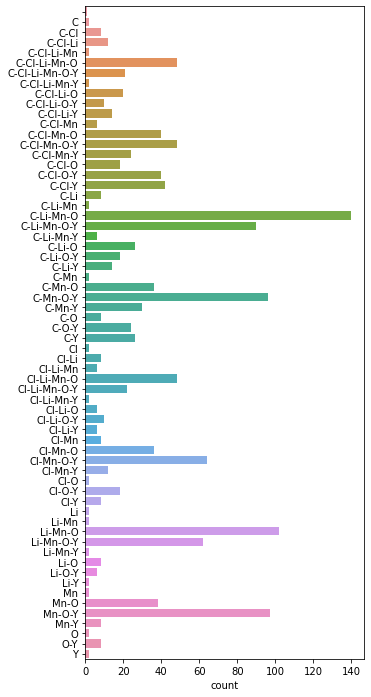

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(5,12))
sns.countplot(y=sorted(list(rn.g.vp["chemsys"])),orient="v");

# Example 2: Y$_2$Mn$_2$O$_7$ assisted metathesis

Now that we have shown step-by-step how the process works for the YMnO$_3$ system, we will no longer walk through each step of the process for the other examples. Instead, see below for how to recreate the results presented in the manuscript.

In [11]:
chemsys = "C-Cl-Mn-Na-O-Y"

precursors = ["Mn2O3", "YCl3","Na2CO3", "O2"]
targets = ["Y2Mn2O7","CO2","NaCl"]

hypothetical_phases = ["Na3MnO3", "Mn8Cl3O10", "Na2MnO3"]

temp = 900
include_metastable = 0.03
k=20
chempots={Element("O"):0}
max_num_combos=5

In [36]:
with MPRester() as mpr:  # requires API key from Materials Project
    all_entries = mpr.get_entries_in_chemsys(chemsys, inc_structure="final") 

/Users/mcdermott/PycharmProjects/pymatgen/pymatgen/ext/matproj.py:581: FutureWarning: __init__ is deprecated
MaterialsProjectCompatibility will be updated with new correction classes as well as new values of corrections and uncertainties in 2020
  entries = MaterialsProjectCompatibility().process_entries(entries)


In [ ]:
rn, paths = run_reaction_network_analysis(all_entries, precursors, targets, temp, include_metastable, k,  chempots, max_num_combos)

This analysis -- particularly path postprocessing -- can take a considerable amount of time to complete (3-4 hours depending on your setup). Instead, you can load the pre-computed results from the paper:

In [16]:
with open("results/y2mn2o7_paths.json") as f:
    paths = json.load(f, cls=MontyDecoder)

In [17]:
cleaned_paths = set()
for idx, p in enumerate(paths):
    interdependent, consolidated_rxn = find_interdependent_rxns(p, precursors, verbose=False)
    if interdependent:
        print(f"Path {idx+1} removed")
        continue
    cleaned_paths.add(p)

Path 4 removed
Path 10 removed
Path 18 removed
Path 19 removed
Path 20 removed
Path 32 removed
Path 34 removed
Path 36 removed
Path 37 removed


In [18]:
hypothetical_phases = {Composition(c) for c in hypothetical_phases}

for idx, p in enumerate(cleaned_paths.copy()):
    if set(p.all_comp) & hypothetical_phases:
        cleaned_paths.remove(p)
        
cleaned_paths = sorted(list(cleaned_paths), key=lambda x: x.total_cost)

In [19]:
for num, path in enumerate(cleaned_paths):
    print(f"Path {num+1}:")
    print(path)

Path 1:
Mn2O3 + Na2CO3 -> CO2 + 2 NaMnO2 (dG = 0.024 eV/atom) 
0.5 O2 + 2 YClO + 2 NaMnO2 -> Y2Mn2O7 + 2 NaCl (dG = -0.164 eV/atom) 
Na2CO3 + YCl3 -> CO2 + YClO + 2 NaCl (dG = -0.178 eV/atom) 

Total Cost: 0.238 | Average Cost: 0.079


Path 2:
0.5 Mn2O3 + Na2CO3 -> CO2 + 0.5 Na4Mn2O5 (dG = 0.12 eV/atom) 
1.308 Mn2O3 + 1.026 Y2O3 -> Y2Mn2O7 + 0.05128 YMn12 (dG = 0.144 eV/atom) 
0.5 O2 + Na4Mn2O5 + 4 YClO -> Y2Mn2O7 + Y2O3 + 4 NaCl (dG = -0.222 eV/atom) 
2.125 O2 + 0.1667 YMn12 + 0.9167 Y2O3 -> Y2Mn2O7 (dG = -0.926 eV/atom) 
Na2CO3 + YCl3 -> CO2 + YClO + 2 NaCl (dG = -0.178 eV/atom) 

Total Cost: 0.246 | Average Cost: 0.049


Path 3:
0.5 Mn2O3 + Na2CO3 -> CO2 + 0.5 Na4Mn2O5 (dG = 0.12 eV/atom) 
0.25 O2 + 0.5 Mn2O3 -> MnO2 (dG = -0.058 eV/atom) 
0.5 O2 + Na4Mn2O5 + 4 YClO -> Y2Mn2O7 + Y2O3 + 4 NaCl (dG = -0.222 eV/atom) 
Na2CO3 + YCl3 -> CO2 + YClO + 2 NaCl (dG = -0.178 eV/atom) 
2 MnO2 + Y2O3 -> Y2Mn2O7 (dG = -0.07 eV/atom) 

Total Cost: 0.246 | Average Cost: 0.049


Path 4:
Mn2O3 + Na2C

### Pandas view

The function below (*create_total_path_df*), is useful for transforming the pathway results to a Pandas DataFrame for convenience.

In [30]:
import pandas 

def create_total_path_df(paths, latex=False):
    path_dict = []
    for idx,p in enumerate(paths):
        rxn_dict_items = sorted(list(p.rxn_dict.items()), key=lambda x: x[1])
        for rxn,cost in rxn_dict_items:
            dG = rxn.calculated_reaction_energy / sum(
                [rxn.get_el_amount(elem) for elem in rxn.elements])
            if latex:
                path_dict.append({"Path":idx+1, r"Reactions":rf"\ce{{{str(rxn)}}}",
                                  r"$\Delta$G$_{rxn}$ (eV/atom)":dG,"Cost":cost,"Total Cost":round(p.total_cost,3)})
            else:
                path_dict.append({"path":idx+1,"rxn":rxn,"dG":round(dG,4),"cost":round(cost,4), "total_cost":round(p.total_cost,3)})
            
    df = pandas.DataFrame(path_dict)
    
    if latex:
        df = df.set_index(["Path","Total Cost","Reactions"])
    else:
        df = df.set_index(["path","total_cost","rxn"])
                     
    return df


In [33]:
df = create_total_path_df(cleaned_paths)
df

dG  \
path total_cost rxn                                                          
1    0.238      Na2CO3 + YCl3 -> CO2 + YClO + 2 NaCl               -0.1776   
                0.5 O2 + 2 YClO + 2 NaMnO2 -> Y2Mn2O7 + 2 NaCl     -0.1644   
                Mn2O3 + Na2CO3 -> CO2 + 2 NaMnO2                    0.0240   
2    0.246      2.125 O2 + 0.1667 YMn12 + 0.9167 Y2O3 -> Y2Mn2O7   -0.9265   
                0.5 O2 + Na4Mn2O5 + 4 YClO -> Y2Mn2O7 + Y2O3 + ... -0.2220   
...                                                                    ...   
23   0.294      Na2CO3 -> CO2 + Na2O                                0.3278   
24   0.294      2.125 O2 + 0.1667 YMn12 + 0.9167 Y2O3 -> Y2Mn2O7   -0.9265   
                0.5 O2 + 2 Na5MnO4 + 3.333 YCl3 -> Y2Mn2O7 + 0.... -0.4959   
                1.308 Mn2O3 + 1.026 Y2O3 -> Y2Mn2O7 + 0.05128 Y...  0.1436   
                0.2 Mn2O3 + Na2CO3 -> CO2 + 0.4 Na5MnO4             0.2338   

                                                                      cost  
path total_cost rxn                                                         
1    0.238      Na2CO3 + YCl3 -> CO2 + YClO + 2 NaCl                0.2263  
                0.5 O2 + 2 YClO + 2 NaMnO2 -> Y2Mn2O7 + 2 NaCl      0.2290  
                Mn2O3 + Na2CO3 -> CO2 + 2 NaMnO2                    0.2706  
2    0.246      2.125 O2 + 0.1667 YMn12 + 0.9167 Y2O3 -> Y2Mn2O7    0.1134  
                0.5 O2 + Na4Mn2O5 + 4 YClO -> Y2Mn2O7 + Y2O3 + ...  0.2175  
...                                                                    ...  
23   0.294      Na2CO3 -> CO2 + Na2O                                0.3514  
24   0.294      2.125 O2 + 0.1667 YMn12 + 0.9167 Y2O3 -> Y2Mn2O7    0.1134  
                0.5 O2 + 2 Na5MnO4 + 3.333 YCl3 -> Y2Mn2O7 + 0....  0.1695  
                1.308 Mn2O3 + 1.026 Y2O3 -> Y2Mn2O7 + 0.05128 Y...  0.3002  
                0.2 Mn2O3 + Na2CO3 -> CO2 + 0.4 Na5MnO4             0.3244  

[111 rows x 2 columns]

# Example 3: Fe$_2$SiS$_4$ synthesis from iron silicide precursors

In [50]:
chemsys = "Fe-S-Si"

precursors = ["Fe3Si", "Fe5Si3", "S"]
targets = ["Fe2SiS4"]

hypothetical_phases = ["SiS","SiS4"]

temp = 900
include_metastable = 0.5
k=75
max_num_combos=6

In [51]:
with MPRester() as mpr:  # requires API key from Materials Project
    all_entries = mpr.get_entries_in_chemsys(chemsys, inc_structure="final") 

In [ ]:
rn, paths = run_reaction_network_analysis(all_entries, precursors, targets, temp, include_metastable, k,  chempots, max_num_combos)

In [40]:
with open("results/fe2sis4_paths.json") as f:
    paths = json.load(f, cls=MontyDecoder)

In [41]:
cleaned_paths = set()
for idx, p in enumerate(paths):
    interdependent, consolidated_rxn = find_interdependent_rxns(p, precursors, verbose=False)
    if interdependent:
        print(f"Path {idx+1} removed")
        continue
    cleaned_paths.add(p)

In [42]:
hypothetical_phases = {Composition(c) for c in hypothetical_phases}

for idx, p in enumerate(cleaned_paths.copy()):
    if set(p.all_comp) & hypothetical_phases:
        cleaned_paths.remove(p)
        
cleaned_paths = sorted(list(cleaned_paths), key=lambda x: x.total_cost)

In [43]:
for num, path in enumerate(cleaned_paths):
    print(f"Path {num+1}:")
    print(path)

Path 1:
5 S + Fe3Si -> Fe2SiS4 + FeS (dG = -0.586 eV/atom) 
0.4286 Fe5Si3 + 4 S -> Fe2SiS4 + 0.1429 FeSi2 (dG = -0.543 eV/atom) 
0.6667 FeSi2 + 3.333 S -> SiS2 + 0.3333 Fe2SiS4 (dG = -0.787 eV/atom) 
SiS2 + 2 FeS -> Fe2SiS4 (dG = 0.27 eV/atom) 

Total Cost: 0.177 | Average Cost: 0.044


Path 2:
5 S + Fe3Si -> Fe2SiS4 + FeS (dG = -0.586 eV/atom) 
0.4286 Fe5Si3 + 4 S -> Fe2SiS4 + 0.1429 FeSi2 (dG = -0.543 eV/atom) 
0.6667 FeSi2 + 3.333 S -> SiS2 + 0.3333 Fe2SiS4 (dG = -0.787 eV/atom) 
S + 0.4 Fe3Si -> FeS + 0.2 FeSi2 (dG = -0.545 eV/atom) 
SiS2 + 2 FeS -> Fe2SiS4 (dG = 0.27 eV/atom) 

Total Cost: 0.177 | Average Cost: 0.035


Path 3:
5 S + Fe3Si -> Fe2SiS4 + FeS (dG = -0.586 eV/atom) 
0.4286 Fe5Si3 + 4 S -> Fe2SiS4 + 0.1429 FeSi2 (dG = -0.543 eV/atom) 
0.6667 FeSi2 + 3.333 S -> SiS2 + 0.3333 Fe2SiS4 (dG = -0.787 eV/atom) 
2 FeSi + 6 S -> SiS2 + Fe2SiS4 (dG = -0.632 eV/atom) 
S + 0.5 Fe3Si -> FeS + 0.5 FeSi (dG = -0.509 eV/atom) 
SiS2 + 2 FeS -> Fe2SiS4 (dG = 0.27 eV/atom) 

Total Cost: 0

In [44]:
df = create_total_path_df(cleaned_paths)
df

dG  \
path total_cost rxn                                                       
1    0.177      0.6667 FeSi2 + 3.333 S -> SiS2 + 0.3333 Fe2SiS4 -0.7870   
                5 S + Fe3Si -> Fe2SiS4 + FeS                    -0.5856   
                0.4286 Fe5Si3 + 4 S -> Fe2SiS4 + 0.1429 FeSi2   -0.5426   
                SiS2 + 2 FeS -> Fe2SiS4                          0.2703   
2    0.177      0.6667 FeSi2 + 3.333 S -> SiS2 + 0.3333 Fe2SiS4 -0.7870   
...                                                                 ...   
48   0.209      SiS2 + 2 FeS -> Fe2SiS4                          0.2703   
49   0.210      2 FeSi + 6 S -> SiS2 + Fe2SiS4                  -0.6324   
                S + 0.5 Fe3Si -> FeS + 0.5 FeSi                 -0.5090   
                0.5 Fe5Si3 + S -> FeS + 1.5 FeSi                -0.3910   
                SiS2 + 2 FeS -> Fe2SiS4                          0.2703   

                                                                   cost  
path total_cost rxn                                                      
1    0.177      0.6667 FeSi2 + 3.333 S -> SiS2 + 0.3333 Fe2SiS4  0.1293  
                5 S + Fe3Si -> Fe2SiS4 + FeS                     0.1561  
                0.4286 Fe5Si3 + 4 S -> Fe2SiS4 + 0.1429 FeSi2    0.1624  
                SiS2 + 2 FeS -> Fe2SiS4                          0.3347  
2    0.177      0.6667 FeSi2 + 3.333 S -> SiS2 + 0.3333 Fe2SiS4  0.1293  
...                                                                 ...  
48   0.209      SiS2 + 2 FeS -> Fe2SiS4                          0.3347  
49   0.210      2 FeSi + 6 S -> SiS2 + Fe2SiS4                   0.1494  
                S + 0.5 Fe3Si -> FeS + 0.5 FeSi                  0.1675  
                0.5 Fe5Si3 + S -> FeS + 1.5 FeSi                 0.1866  
                SiS2 + 2 FeS -> Fe2SiS4                          0.3347  

[258 rows x 2 columns]

# Example 4: YBCO synthesis from barium peroxide

In [ ]:
chemsys = "Ba-Cu-O-Y"

precursors = ["Y2O3", "BaO2", "CuO"]
targets = ["Y2Ba4Cu6O13", "O2"]

hypothetical_phases = ["Cu8O7","Ba8Cu8O19","Ba3Y2O6"]

temp = 1200
include_metastable = 0.1
k=20
chempots={Element("O"):0}
max_num_combos=5

In [ ]:
rn, paths = run_reaction_network_analysis(all_entries, precursors, targets, temp, include_metastable, k,  chempots, max_num_combos)

In [53]:
with open("results/ybco_paths.json") as f:
    paths = json.load(f, cls=MontyDecoder)

In [54]:
cleaned_paths = set()
for idx, p in enumerate(paths):
    interdependent, consolidated_rxn = find_interdependent_rxns(p, precursors, verbose=False)
    if interdependent:
        print(f"Path {idx+1} removed")
        continue
    cleaned_paths.add(p)

In [55]:
hypothetical_phases = {Composition(c) for c in hypothetical_phases}

for idx, p in enumerate(cleaned_paths.copy()):
    if set(p.all_comp) & hypothetical_phases:
        cleaned_paths.remove(p)
        
cleaned_paths = sorted(list(cleaned_paths), key=lambda x: x.total_cost)

In [56]:
for num, path in enumerate(cleaned_paths):
    print(f"Path {num+1}:")
    print(path)

Path 1:
BaO2 + CuO -> BaCuO2 + 0.5 O2 (dG = -0.16 eV/atom) 
Ba4Y2O7 + 6 CuO -> Ba4Y2Cu6O13 (dG = -0.137 eV/atom) 
3 Y2O3 + 12 BaCuO2 -> Ba4Y2O7 + 2 Ba4Y2Cu6O13 (dG = 0.039 eV/atom) 

Total Cost: 0.18 | Average Cost: 0.06


Path 2:
BaO2 + CuO -> BaCuO2 + 0.5 O2 (dG = -0.16 eV/atom) 
4 Ba3Y2O6 + 20 CuO -> Y2Cu2O5 + 3 Ba4Y2Cu6O13 (dG = -0.094 eV/atom) 
2.5 Y2O3 + 9 BaCuO2 -> Ba3Y2O6 + 1.5 Ba4Y2Cu6O13 (dG = 0.025 eV/atom) 
2 BaO2 + 2 CuO -> Ba2Cu2O5 + 0.5 O2 (dG = -0.225 eV/atom) 
2 Ba2Cu2O5 + Y2Cu2O5 -> O2 + Ba4Y2Cu6O13 (dG = 0.039 eV/atom) 

Total Cost: 0.181 | Average Cost: 0.036


Path 3:
BaO2 + CuO -> BaCuO2 + 0.5 O2 (dG = -0.16 eV/atom) 
4 Ba3Y2O6 + 20 CuO -> Y2Cu2O5 + 3 Ba4Y2Cu6O13 (dG = -0.094 eV/atom) 
2.5 Y2O3 + 9 BaCuO2 -> Ba3Y2O6 + 1.5 Ba4Y2Cu6O13 (dG = 0.025 eV/atom) 
Y2Cu2O5 + 4 BaCuO2 -> Ba4Y2Cu6O13 (dG = -0.01 eV/atom) 

Total Cost: 0.181 | Average Cost: 0.045


Path 4:
BaO2 + CuO -> BaCuO2 + 0.5 O2 (dG = -0.16 eV/atom) 
4 Ba3Y2O6 + 20 CuO -> Y2Cu2O5 + 3 Ba4Y2Cu6O13 (dG = -

In [57]:
df = create_total_path_df(cleaned_paths)
df

dG    cost
path total_cost rxn                                                          
1    0.180      BaO2 + CuO -> BaCuO2 + 0.5 O2                 -0.1599  0.1772
                Ba4Y2O7 + 6 CuO -> Ba4Y2Cu6O13                -0.1367  0.1810
                3 Y2O3 + 12 BaCuO2 -> Ba4Y2O7 + 2 Ba4Y2Cu6O13  0.0385  0.2122
2    0.181      2 BaO2 + 2 CuO -> Ba2Cu2O5 + 0.5 O2           -0.2245  0.1670
                BaO2 + CuO -> BaCuO2 + 0.5 O2                 -0.1599  0.1772
...                                                               ...     ...
42   0.208      8 CuO -> Cu8O7 + 0.5 O2                        0.0998  0.2242
                4 CuO -> Cu4O3 + 0.5 O2                        0.1051  0.2253
43   0.217      16 BaO2 + 6 Cu4O3 -> O2 + 8 Ba2(CuO2)3        -0.3028  0.1554
                Y2O3 + 2 Ba2(CuO2)3 -> O2 + Ba4Y2Cu6O13        0.0749  0.2193
                4 CuO -> Cu4O3 + 0.5 O2                        0.1051  0.2253

[187 rows x 2 columns]